# Water Clasification LightGBM CPU

Version: DEMO

ILAB Team

Kernel to use:
- (ADAPT PRISM) `Python [conda env:ilab]`

This is a demo notebook showcasing how the ILAB team uses sklearn capabilities to perform efficient CPU-based training of a LightGBM classifier algorithm. This notebook also demonstates how to use a raster as a test data-set for the trained model.

In [1]:
import sklearn
sklearn.__version__

'1.1.2'

In [2]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys
from pprint import pprint
import time

import optuna

from sklearn.ensemble import HistGradientBoostingClassifier

# Scikit learn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
DATA_TYPE = np.float32

In [4]:
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Add names from above to this list to drop them from training and testing.

For example:

```python
columnsToDrop = ['sur_refl_b01_1', 'sur_refl_b07_1', 'ndwi1']
```

In [5]:
columnsToDrop = []

This is a 1000 row training dataset which has columns for all the features listed in v_names. MODIS MOD09GA and MOD09GQ were the data sources.

In [6]:
dfPath = '../data/WaterClassificationPowell.parquet.gzip'

In [7]:
outputRasterPath = '.'

In [8]:
!pip install fastparquet

In [9]:
df = pd.read_parquet(dfPath).astype(DATA_TYPE)
df = df.drop(columns=columnsToDrop)
X = df.drop(['water'], axis=1)
y = df['water']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

## Load in data for use of visualizations 
(skip this if you just want to train model)

In [11]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [12]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,800.0,1208.814941,1294.360474,15.000000,243.750000,877.000000,1893.500000,9222.000000
sur_refl_b02_1,800.0,1577.988770,1567.905396,1.000000,179.500000,1290.500000,2683.750000,8837.000000
sur_refl_b03_1,800.0,729.177490,985.208801,-100.000000,288.000000,562.000000,853.000000,8909.000000
sur_refl_b04_1,800.0,1019.117493,1049.669678,6.000000,410.750000,830.500000,1313.250000,9162.000000
sur_refl_b05_1,800.0,1982.163696,1479.083374,-92.000000,547.750000,1829.500000,3231.250000,5706.000000
sur_refl_b06_1,800.0,1956.963745,1554.545410,45.000000,514.250000,1552.500000,3279.250000,5812.000000
sur_refl_b07_1,800.0,1613.043701,1408.529297,0.000000,316.750000,1200.000000,2762.000000,5132.000000
ndvi,800.0,104.779083,2492.591309,-9444.444336,-1350.337830,754.893646,1759.305237,8587.457031
ndwi1,800.0,-2380.736328,3336.646484,-9862.069336,-4570.242188,-1638.265198,-849.774597,8685.882812
ndwi2,800.0,-929.072754,3795.141113,-9692.307617,-2638.875000,-714.494232,765.722061,10000.000000


In [16]:
cl = HistGradientBoostingClassifier()

In [17]:
cl.get_params()

{'categorical_features': None,
 'early_stopping': 'auto',
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Random Forest Model

### Model Definition

In [49]:
def objective(trial):
    hyperparameters = {
        # Maximum number of leaves each weak learner has
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 16, 2**15),
        # L2 regularization weight.
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-8, 1.0, log=True),
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth":  trial.suggest_int("max_depth", 3, 20, step=1), 
        # minimum child weight, larger the term more conservative the tree.
        "learning_rate":  trial.suggest_float("learning_rate", 3e-4, 0.3, log=True), 
    }
    classifier = HistGradientBoostingClassifier(**hyperparameters)
    scores = []
    for trainIdx, testIdx in kf.split(X_train):
        X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
        y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
        classifier.fit(X_train_valid, 
                       y_train_valid)
        preds = classifier.predict(X_test_valid)
        f1 = f1_score(y_test_valid, preds)
        print('F1 Score: {}'.format(f1))
        scores.append(f1)
    print('Mean F1 score: {}'.format(sum(scores)/len(scores)))
    return f1

## Set the search space

Set the search space for the hyperparameter tuning to search through once. This needs to be in conjunction with the `trial.suggest...` part of the hyperparameters dictionary defined aboce. 

Ex.

If `max_depth` is defined in `hyperparameters` in the `objective` function above as such

`"max_depth":  trial.suggest_int("max_depth", 3, 15, step=1),` 

then we need to pair that with the limited search space below as such:

`search_space={"max_depth":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}`

This is not the most ideal way of ensuring that trials are not repeated, however it works for now. 

In [50]:
search_space={
    "max_depth":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}

### Set number of trials and timeout

Set the number of trials `n_trials=<num of desired trials>` and the maximum time for the total study `timeout=<timeout in minutes>*60`

In [51]:
optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(study_name='hGBM hyperparameter tuning - cpu', 
                            direction='maximize',
                           ) # sampler=optuna.samplers.GridSampler(search_space))

study.optimize(objective, n_trials=20, timeout=10*60)

[I 2022-08-17 10:59:26,059] A new study created in memory with name: hGBM hyperparameter tuning - cpu


F1 Score: 0.9625000000000001
F1 Score: 0.9689440993788819
F1 Score: 0.980891719745223


[I 2022-08-17 10:59:26,486] Trial 0 finished with value: 0.9681528662420381 and parameters: {'max_leaf_nodes': 24095, 'l2_regularization': 2.784591813650037e-06, 'max_depth': 3, 'learning_rate': 0.0016745380779159154}. Best is trial 0 with value: 0.9681528662420381.


F1 Score: 0.9878048780487805
F1 Score: 0.9681528662420381
Mean F1 score: 0.9736587126829848
F1 Score: 0.9625000000000001
F1 Score: 0.9689440993788819
F1 Score: 0.980891719745223


[I 2022-08-17 10:59:26,989] Trial 1 finished with value: 0.9681528662420381 and parameters: {'max_leaf_nodes': 18211, 'l2_regularization': 0.000548082295152341, 'max_depth': 16, 'learning_rate': 0.0003613516351652427}. Best is trial 0 with value: 0.9681528662420381.


F1 Score: 0.9878048780487805
F1 Score: 0.9681528662420381
Mean F1 score: 0.9736587126829848
F1 Score: 0.9693251533742331
F1 Score: 0.975609756097561
F1 Score: 0.9937106918238994
F1 Score: 0.9938650306748467


[I 2022-08-17 10:59:27,765] Trial 2 finished with value: 0.9811320754716981 and parameters: {'max_leaf_nodes': 31090, 'l2_regularization': 0.0186043669493791, 'max_depth': 8, 'learning_rate': 0.08337908542167133}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9811320754716981
Mean F1 score: 0.9827285414884477
F1 Score: 0.9625000000000001
F1 Score: 0.9689440993788819
F1 Score: 0.980891719745223
F1 Score: 0.9878048780487805


[I 2022-08-17 10:59:28,338] Trial 3 finished with value: 0.9681528662420381 and parameters: {'max_leaf_nodes': 32503, 'l2_regularization': 0.002014099249901498, 'max_depth': 8, 'learning_rate': 0.0004656000547134317}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9681528662420381
Mean F1 score: 0.9736587126829848
F1 Score: 0.9625000000000001
F1 Score: 0.9753086419753086
F1 Score: 0.9937106918238994


[I 2022-08-17 10:59:28,925] Trial 4 finished with value: 0.9746835443037976 and parameters: {'max_leaf_nodes': 5279, 'l2_regularization': 3.384072744732481e-06, 'max_depth': 18, 'learning_rate': 0.0147371761952924}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9938650306748467
F1 Score: 0.9746835443037976
Mean F1 score: 0.9800135817555706
F1 Score: 0.9625000000000001
F1 Score: 0.9689440993788819
F1 Score: 0.980891719745223


[I 2022-08-17 10:59:29,425] Trial 5 finished with value: 0.9681528662420381 and parameters: {'max_leaf_nodes': 16629, 'l2_regularization': 0.09787029637984636, 'max_depth': 6, 'learning_rate': 0.0010505011608098942}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9878048780487805
F1 Score: 0.9681528662420381
Mean F1 score: 0.9736587126829848
F1 Score: 0.9634146341463415
F1 Score: 0.9815950920245398
F1 Score: 0.9937106918238994


[I 2022-08-17 10:59:29,981] Trial 6 finished with value: 0.9811320754716981 and parameters: {'max_leaf_nodes': 25921, 'l2_regularization': 0.00016026562674013127, 'max_depth': 16, 'learning_rate': 0.051757501010479094}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9938650306748467
F1 Score: 0.9811320754716981
Mean F1 score: 0.9827435048282652
F1 Score: 0.9625000000000001
F1 Score: 0.9689440993788819
F1 Score: 0.980891719745223
F1 Score: 0.9878048780487805


[I 2022-08-17 10:59:30,458] Trial 7 finished with value: 0.9681528662420381 and parameters: {'max_leaf_nodes': 30280, 'l2_regularization': 0.0009696454556038286, 'max_depth': 12, 'learning_rate': 0.0007928462143977295}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9681528662420381
Mean F1 score: 0.9736587126829848
F1 Score: 0.9625000000000001
F1 Score: 0.9689440993788819


[I 2022-08-17 10:59:30,872] Trial 8 finished with value: 0.9615384615384615 and parameters: {'max_leaf_nodes': 30464, 'l2_regularization': 0.08434837091438688, 'max_depth': 12, 'learning_rate': 0.005262945629691849}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.980891719745223
F1 Score: 0.9878048780487805
F1 Score: 0.9615384615384615
Mean F1 score: 0.9723358317422693
F1 Score: 0.9625000000000001
F1 Score: 0.9689440993788819
F1 Score: 0.980891719745223
F1 Score: 0.9878048780487805


[I 2022-08-17 10:59:31,676] Trial 9 finished with value: 0.9615384615384615 and parameters: {'max_leaf_nodes': 18934, 'l2_regularization': 9.45584920619816e-07, 'max_depth': 16, 'learning_rate': 0.0068139858157031585}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9615384615384615
Mean F1 score: 0.9723358317422693
F1 Score: 0.9693251533742331
F1 Score: 0.9815950920245398
F1 Score: 1.0


[I 2022-08-17 10:59:32,293] Trial 10 finished with value: 0.9811320754716981 and parameters: {'max_leaf_nodes': 5716, 'l2_regularization': 1.270134231281678e-08, 'max_depth': 7, 'learning_rate': 0.22854499852970675}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9938650306748467
F1 Score: 0.9811320754716981
Mean F1 score: 0.9851834703090635
F1 Score: 0.9693251533742331
F1 Score: 0.975609756097561
F1 Score: 1.0


[I 2022-08-17 10:59:32,883] Trial 11 finished with value: 0.9811320754716981 and parameters: {'max_leaf_nodes': 25292, 'l2_regularization': 0.01504080916654079, 'max_depth': 20, 'learning_rate': 0.09496914052888408}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9938650306748467
F1 Score: 0.9811320754716981
Mean F1 score: 0.9839864031236678
F1 Score: 0.9634146341463415
F1 Score: 0.9815950920245398
F1 Score: 1.0
F1 Score: 0.9938650306748467


[I 2022-08-17 10:59:33,600] Trial 12 finished with value: 0.9811320754716981 and parameters: {'max_leaf_nodes': 24469, 'l2_regularization': 4.5691224177068625e-05, 'max_depth': 10, 'learning_rate': 0.047342418651573875}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9811320754716981
Mean F1 score: 0.9840013664634852
F1 Score: 0.9753086419753086
F1 Score: 0.9876543209876543
F1 Score: 0.9937106918238994


[I 2022-08-17 10:59:34,226] Trial 13 finished with value: 0.9746835443037976 and parameters: {'max_leaf_nodes': 25655, 'l2_regularization': 4.0647016023415266e-05, 'max_depth': 15, 'learning_rate': 0.0330713332142808}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9938650306748467
F1 Score: 0.9746835443037976
Mean F1 score: 0.9850444459531014
F1 Score: 0.9693251533742331
F1 Score: 0.975609756097561
F1 Score: 1.0
F1 Score: 0.9938650306748467


[I 2022-08-17 10:59:34,916] Trial 14 finished with value: 0.9811320754716981 and parameters: {'max_leaf_nodes': 11000, 'l2_regularization': 0.3737719483166422, 'max_depth': 14, 'learning_rate': 0.2611583774139259}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9811320754716981
Mean F1 score: 0.9839864031236678
F1 Score: 0.9693251533742331
F1 Score: 0.9815950920245398


[I 2022-08-17 10:59:35,352] Trial 15 finished with value: 0.9746835443037976 and parameters: {'max_leaf_nodes': 28213, 'l2_regularization': 0.00845230463488185, 'max_depth': 3, 'learning_rate': 0.08310806788632419}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 1.0
F1 Score: 0.9938650306748467
F1 Score: 0.9746835443037976
Mean F1 score: 0.9838937640754833
F1 Score: 0.9689440993788819
F1 Score: 0.9876543209876543
F1 Score: 0.9937106918238994
F1 Score: 0.9938650306748467


[I 2022-08-17 10:59:36,019] Trial 16 finished with value: 0.9746835443037976 and parameters: {'max_leaf_nodes': 21880, 'l2_regularization': 6.957389896114397e-05, 'max_depth': 10, 'learning_rate': 0.02585280082230308}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9746835443037976
Mean F1 score: 0.983771537433816
F1 Score: 0.9634146341463415
F1 Score: 0.975609756097561
F1 Score: 1.0


[I 2022-08-17 10:59:36,657] Trial 17 finished with value: 0.9811320754716981 and parameters: {'max_leaf_nodes': 9212, 'l2_regularization': 0.49252708484314733, 'max_depth': 14, 'learning_rate': 0.17830857204617048}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9938650306748467
F1 Score: 0.9811320754716981
Mean F1 score: 0.9828042992780894
F1 Score: 0.9634146341463415
F1 Score: 0.975609756097561
F1 Score: 1.0


[I 2022-08-17 10:59:37,176] Trial 18 finished with value: 0.9811320754716981 and parameters: {'max_leaf_nodes': 11435, 'l2_regularization': 0.9743449697051374, 'max_depth': 5, 'learning_rate': 0.14888891573425553}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9938650306748467
F1 Score: 0.9811320754716981
Mean F1 score: 0.9828042992780894
F1 Score: 0.9693251533742331
F1 Score: 0.9815950920245398
F1 Score: 0.9937106918238994


[I 2022-08-17 10:59:37,943] Trial 19 finished with value: 0.9811320754716981 and parameters: {'max_leaf_nodes': 1294, 'l2_regularization': 0.022087532842364303, 'max_depth': 5, 'learning_rate': 0.10836921929824649}. Best is trial 2 with value: 0.9811320754716981.


F1 Score: 0.9938650306748467
F1 Score: 0.9811320754716981
Mean F1 score: 0.9839256086738434


In [52]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)
print(trial_score)

trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

study_df = study.trials_dataframe()
study_df.to_csv("hyperopt_tuning_trial_{}_hgbm.csv".format(
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')))

Number of finished trials: 20
{'max_leaf_nodes': 31090, 'l2_regularization': 0.0186043669493791, 'max_depth': 8, 'learning_rate': 0.08337908542167133}
0.9811320754716981


In [53]:
study_df

,number,value,datetime_start,datetime_complete,duration,params_l2_regularization,params_learning_rate,params_max_depth,params_max_leaf_nodes,state
0,0,0.968153,2022-08-17 10:59:26.061241,2022-08-17 10:59:26.485977,0 days 00:00:00.424736,2.784592e-06,0.001675,3,24095,COMPLETE
1,1,0.968153,2022-08-17 10:59:26.486958,2022-08-17 10:59:26.988768,0 days 00:00:00.501810,5.480823e-04,0.000361,16,18211,COMPLETE
2,2,0.981132,2022-08-17 10:59:26.989679,2022-08-17 10:59:27.765755,0 days 00:00:00.776076,1.860437e-02,0.083379,8,31090,COMPLETE
3,3,0.968153,2022-08-17 10:59:27.766656,2022-08-17 10:59:28.337816,0 days 00:00:00.571160,2.014099e-03,0.000466,8,32503,COMPLETE
4,4,0.974684,2022-08-17 10:59:28.338718,2022-08-17 10:59:28.925530,0 days 00:00:00.586812,3.384073e-06,0.014737,18,5279,COMPLETE
5,5,0.968153,2022-08-17 10:59:28.926413,2022-08-17 10:59:29.425677,0 days 00:00:00.499264,9.787030e-02,0.001051,6,16629,COMPLETE
6,6,0.981132,2022-08-17 10:59:29.426586,2022-08-17 10:59:29.981734,0 days 00:00:00.555148,1.602656e-04,0.051758,16,25921,COMPLETE
7,7,0.968153,2022-08-17 10:59:29.982644,2022-08-17 10:59:30.458011,0 days 00:00:00.475367,9.696455e-04,0.000793,12,30280,COMPLETE
8,8,0.961538,2022-08-17 10:59:30.458893,2022-08-17 10:59:30.872464,0 days 00:00:00.413571,8.434837e-02,0.005263,12,30464,COMPLETE
9,9,0.961538,2022-08-17 10:59:30.873731,2022-08-17 10:59:31.676226,0 days 00:00:00.802495,9.455849e-07,0.006814,16,18934,COMPLETE


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

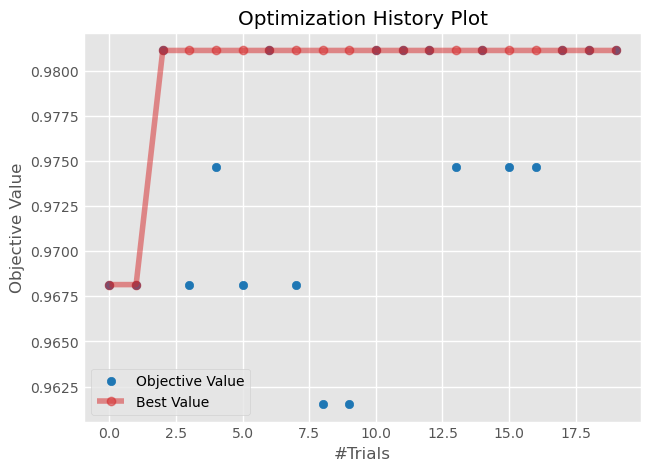

In [54]:
optuna.visualization.matplotlib.plot_optimization_history(study)

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

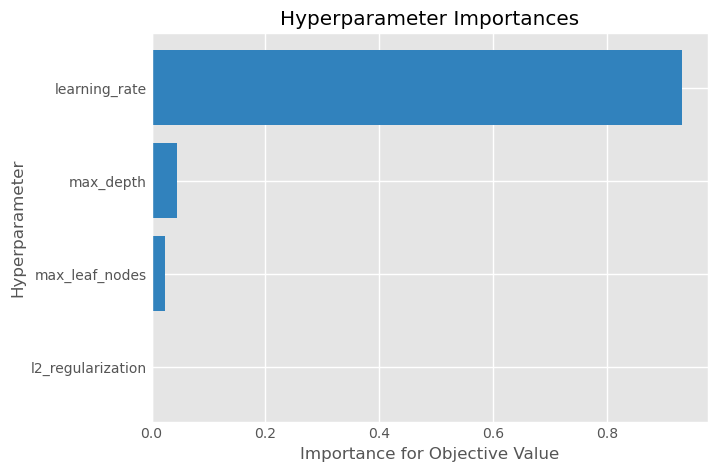

In [55]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [57]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,800.0,1214.750000,1295.685913,8.000000,240.500000,875.000000,1900.500000,9045.000000
sur_refl_b02_1,800.0,1580.621216,1559.198486,1.000000,172.000000,1410.000000,2683.750000,8795.000000
sur_refl_b03_1,800.0,744.873779,1023.064392,-100.000000,286.000000,544.000000,841.750000,8844.000000
sur_refl_b04_1,800.0,1027.583740,1077.609741,6.000000,406.750000,805.000000,1293.000000,9056.000000
sur_refl_b05_1,800.0,1966.123779,1469.749634,-20.000000,538.500000,1824.000000,3241.750000,5706.000000
sur_refl_b06_1,800.0,1923.808716,1537.034058,45.000000,504.750000,1447.500000,3214.250000,5851.000000
sur_refl_b07_1,800.0,1579.436279,1387.586670,0.000000,311.500000,1169.500000,2705.250000,5370.000000
ndvi,800.0,68.154953,2510.638672,-8750.000000,-1529.734680,640.278107,1759.345062,6603.590332
ndwi1,800.0,-2303.447754,3440.317139,-9829.059570,-4588.879150,-1571.842407,-728.143387,8823.803711
ndwi2,800.0,-868.831726,3891.604004,-9607.842773,-2754.657166,-656.777618,881.896194,10000.000000


In [58]:
hyperparameters = best_trial_params
print('Using these params:')
pprint(hyperparameters)
classifier = HistGradientBoostingClassifier(**hyperparameters)

Using these params:
{'l2_regularization': 0.0186043669493791,
 'learning_rate': 0.08337908542167133,
 'max_depth': 8,
 'max_leaf_nodes': 31090}


In [59]:
%%time

classifier.fit(X_train, y_train)

CPU times: user 1.33 s, sys: 44.4 ms, total: 1.37 s
Wall time: 127 ms


HistGradientBoostingClassifier(l2_regularization=0.0186043669493791,
                               learning_rate=0.08337908542167133, max_depth=8,
                               max_leaf_nodes=31090)

### Get model metrics

In [60]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.975

In [61]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [62]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [63]:
print('Train Performance')
print('-------------------------------------------------------')
print(classification_report(y_train, train_predictions))
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Train Performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       396
         1.0       1.00      1.00      1.00       404

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       104
         1.0       0.99      0.96      0.97        96

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

Test Recall
-------------------------------------------------------
0.9903846153846154
Confusion Matrix
-------------------------------------------------------
[[103   1]
 [  4  92]]


In [64]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

CPU times: user 4.48 s, sys: 139 ms, total: 4.62 s
Wall time: 414 ms


Text(0.5, 0, 'Permutation Importance')

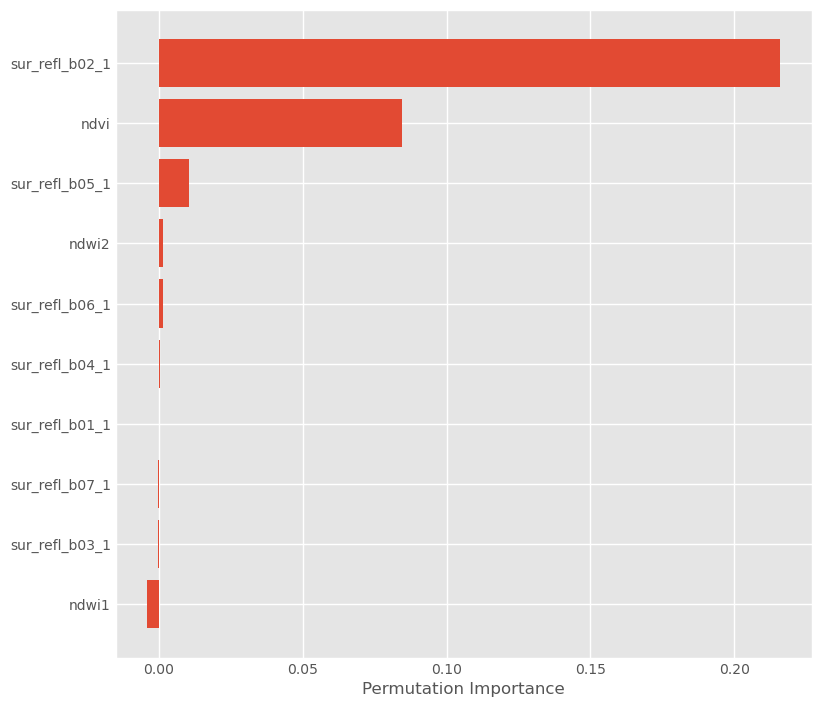

In [65]:
sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [66]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, prediction_probs, y_test_int

## Save the model for future use

In [67]:
model_save_path = './water_classifier_hgbm_cpu.sav'
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: ./water_classifier_hgbm_cpu.sav
HistGradientBoostingClassifier(l2_regularization=0.0186043669493791,
                               learning_rate=0.08337908542167133, max_depth=8,
                               max_leaf_nodes=31090)


['./water_classifier_hgbm_cpu.sav']

# Testing: Raster testing

### Read in data 

These are modified MOD09GA and MOD09GQ products for the 2001 julian day 155. They were modified to be clipped to the Lake Powell region.

In [68]:
fileList = sorted([file for file in glob.glob('../data/IL.*.Powell.*.tif') if 'sur_refl' in file])

In [69]:
def readRastersToArray(fileList):
    rasterProjection = None
    newshp = (1300*1300, 10)
    img = np.empty(newshp, dtype=np.int16)
    for i, fileName in enumerate(fileList):
        ds = gdal.Open(fileName)
        img[:, i] = ds.GetRasterBand(1).ReadAsArray().astype(np.int16).ravel()
        if i == 0:
            rasterProjection = ds.GetProjection()
        ds = None
    img[:, len(fileList)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(fileList)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(fileList)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    return img, rasterProjection

In [70]:
%%time
im, rasterProjection = readRastersToArray(fileList)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 1547  2461   857 ...  2280  -518   510]
 [ 1474  2377   857 ...  2344  -691   337]
 [ 1474  2377   846 ...  2344  -472   623]
 ...
 [ 2358  2979  1028 ...  1163 -1727 -1292]
 [ 2425  3069  1117 ...  1172 -1721 -1216]
 [ 2402  3038  1117 ...  1169 -1770 -1266]]
33.8 MB size
CPU times: user 209 ms, sys: 33 ms, total: 242 ms
Wall time: 242 ms


### Load in the model

In [71]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    print('Converting host array to CPU-based dataframe')
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.float32)
    df = df.drop(columns=columnsToDrop)
    print('Making predictions from raster')
    predictions = classifier.predict(df)
    predictionsProbs = classifier.predict_proba(df)
    return predictions, predictionsProbs, df

In [72]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im)

Converting host array to CPU-based dataframe
Making predictions from raster
CPU times: user 25.7 s, sys: 850 ms, total: 26.5 s
Wall time: 2.5 s


### Description of the predicted probability for each pixel in the raster (no bad-data vals masked yet)

In [73]:
shp = (1300, 1300)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [74]:
shp = (1300, 1300)
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(1300, 1300)

Add QA mask to prediction

In [75]:
qa = [file for file in glob.glob('../data/*.tif') if 'qa' in file][0]
ds = gdal.Open(qa)
qaMask = ds.GetRasterBand(1).ReadAsArray()
output = np.where(qaMask == 0, reshp, -9999)
qaMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [76]:
countNoData = np.count_nonzero(output == -9999)
countLand = np.count_nonzero(output == 0)
countWater = np.count_nonzero(output == 1)
print('Predicted\n No-data occuraces: {}\n Land occurances: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 No-data occuraces: 61568
 Land occurances: 1618386
 Water occurances: 10046


## Output predicted raster to GeoTiff

In [77]:
geoTransform = (-9961223.407, 231.65635, 0.0, 4285642.633667, 0.0, -231.65635)

In [78]:
predictedPath = os.path.join(outputRasterPath, 'PowellPredictedWaterMask.tif')

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, 1300, 1300, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geoTransform)
outDs.SetProjection(rasterProjection)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(output)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

## View predictions with Folium

In [81]:
import folium
from folium import plugins

sys.path.append('../scripts')
import folium_helper

In [82]:
mask_3857 = folium_helper.reproject_to_3857(predictedPath)
mask_d = folium_helper.get_bounds(mask_3857)
mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
folium_helper.cleanup(mask_3857)
mask_b1 = np.where(mask_b1 == -9999, 0, mask_b1)
zeros = np.zeros_like(mask_b1)
mask_rgb = np.dstack((mask_b1, zeros, zeros))

Transform: | 491.82, 0.00,-12749861.52|
| 0.00,-491.82, 4656230.30|
| 0.00, 0.00, 1.00|
Width: 1670 Height: 770


In [83]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google')


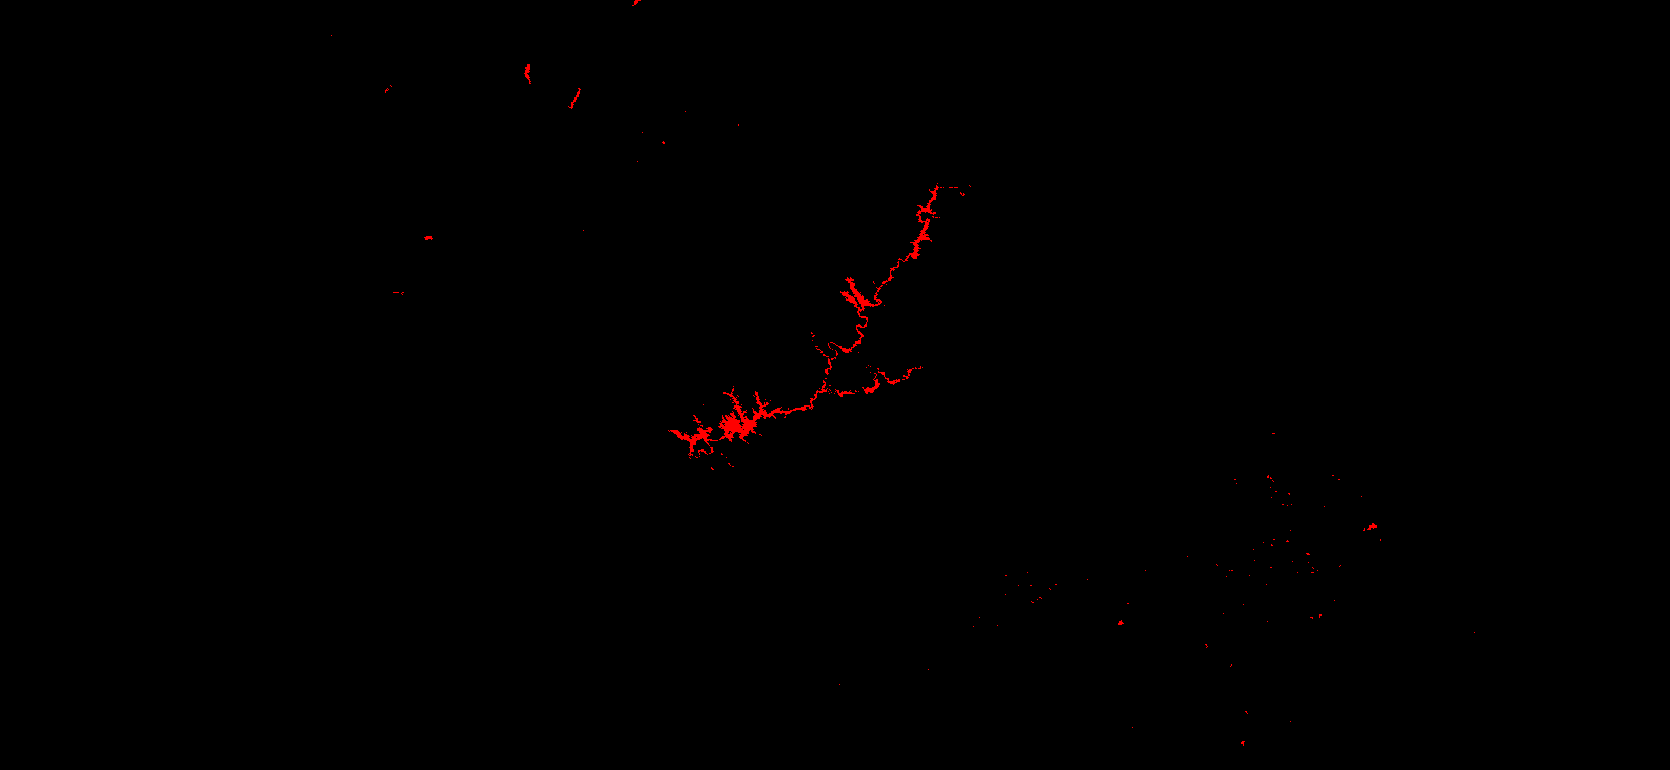

In [84]:
m.add_child(folium_helper.get_overlay(mask_rgb, mask_d, 'Water classification XGBOOST predicted mask', opacity=0.6))
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())